In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import copy
import matplotlib.pyplot as plt

# Make plots inline in Colab
%matplotlib inline

# --- 0.1: Global Experiment Parameters ---
NUM_CLIENTS = 5              # number of federated clients
BATCH_SIZE = 64              # local mini-batch size
LOCAL_EPOCHS = 5             # K (fixed across all experiments)
TOTAL_ROUNDS = 30            # communication rounds (increase to 50 if you have time)
LEARNING_RATE = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

print(f"Device: {DEVICE}")
print(f"Clients: {NUM_CLIENTS}, Rounds: {TOTAL_ROUNDS}, Local epochs K={LOCAL_EPOCHS}")
print(f"LR: {LEARNING_RATE}, Batch Size: {BATCH_SIZE}")

# --- 0.2: Reproducibility ---
def set_global_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_global_seed(SEED)
print(f"Set random seed to {SEED}.")


Device: cuda
Clients: 5, Rounds: 30, Local epochs K=5
LR: 0.01, Batch Size: 64
Set random seed to 42.


In [2]:
# ============================================================================
# STEP 1: MODEL DEFINITION (Simple CNN for CIFAR-10)
# ============================================================================

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Save a fixed initial model state for fair comparison across different α runs
global_model = SimpleCNN().to(DEVICE)
INITIAL_MODEL_STATE = copy.deepcopy(global_model.state_dict())
print("SimpleCNN defined and INITIAL_MODEL_STATE saved.")


SimpleCNN defined and INITIAL_MODEL_STATE saved.


In [ ]:
# ============================================================================
# STEP 2: DATA LOADING (CIFAR-10)
# ============================================================================

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

print("Loading CIFAR-10...")
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_cifar
)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_cifar
)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

if hasattr(train_dataset, "targets"):
    train_labels = np.array(train_dataset.targets)
else:
    train_labels = np.array([train_dataset[i][1] for i in range(len(train_dataset))])

NUM_CLASSES = len(np.unique(train_labels))
print(f"Number of classes: {NUM_CLASSES}")


Loading CIFAR-10...


100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


Train samples: 50000, Test samples: 10000
Number of classes: 10


In [ ]:
# ============================================================================
# STEP 3: DIRICHLET PARTITIONING FOR LABEL HETEROGENEITY
# ============================================================================

def create_dirichlet_partitions(dataset, labels, num_clients, alpha, num_classes):
    """
    Create non-IID client datasets using a Dirichlet distribution over labels.

    Args:
        dataset: full training dataset
        labels: 1D numpy array of class labels for the dataset
        num_clients: number of clients
        alpha: Dirichlet concentration parameter (float)
        num_classes: number of distinct classes

    Returns:
        list_of_subsets: list of torch.utils.data.Subset, one per client
    """
    idx_per_class = [np.where(labels == c)[0] for c in range(num_classes)]

    client_indices = [[] for _ in range(num_clients)]

    for c in range(num_classes):
        idx_c = idx_per_class[c]
        np.random.shuffle(idx_c)

        proportions = np.random.dirichlet(alpha * np.ones(num_clients))

        class_count = len(idx_c)
        samples_per_client = (proportions * class_count).astype(int)

        diff = class_count - samples_per_client.sum()
        for i in np.random.choice(num_clients, diff, replace=True):
            samples_per_client[i] += 1

        start = 0
        for client_id in range(num_clients):
            count = samples_per_client[client_id]
            if count > 0:
                client_indices[client_id].extend(idx_c[start:start + count].tolist())
                start += count

    list_of_subsets = [Subset(dataset, indices) for indices in client_indices]

    return list_of_subsets


def summarize_label_distribution(client_datasets, base_dataset, num_classes):
    """
    Compute per-client label counts (for sanity checking heterogeneity).
    Returns: list of numpy arrays (one per client) with counts per class.
    """
    distributions = []
    for client_ds in client_datasets:
        indices = client_ds.indices
        if hasattr(base_dataset, "targets"):
            labels = np.array(base_dataset.targets)[indices]
        else:
            labels = np.array([base_dataset[i][1] for i in indices])
        counts = np.bincount(labels, minlength=num_classes)
        distributions.append(counts)
    return distributions


def print_label_distribution_summary(distributions, alpha_value, max_clients_to_print=5):
    """
    Print a compact summary of label distribution for a few clients.
    """
    print(f"\n=== Label Distribution Summary for α = {alpha_value} ===")
    num_clients = len(distributions)
    for client_id in range(min(num_clients, max_clients_to_print)):
        counts = distributions[client_id]
        total = counts.sum()
        top_classes = counts.argsort()[::-1][:3]  # top 3 most common classes
        top_info = ", ".join(
            [f"class {c}: {counts[c]} ({counts[c]/total*100:.1f}%)"
             for c in top_classes if counts[c] > 0]
        )
        print(f"Client {client_id} (total {total} samples) -> {top_info}")
    if num_clients > max_clients_to_print:
        print(f"... ({num_clients - max_clients_to_print} more clients not printed)")


In [ ]:
# ============================================================================
# STEP 4: FEDAVG IMPLEMENTATION (Client, Server, Drift, Experiment Runner)
# ============================================================================

class Client:
    def __init__(self, client_id, local_train_loader, device):
        self.client_id = client_id
        self.local_train_loader = local_train_loader
        self.local_data_size = len(local_train_loader.dataset)
        self.device = device

    def local_train(self, global_model_state_dict, K_epochs, lr, criterion):
        local_model = SimpleCNN().to(self.device)
        local_model.load_state_dict(global_model_state_dict)
        local_model.train()

        optimizer = optim.SGD(local_model.parameters(), lr=lr)

        for epoch in range(K_epochs):
            for data, labels in self.local_train_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = local_model(data)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        return local_model.state_dict(), self.local_data_size


class Server:
    def __init__(self, global_model, test_loader, device, criterion):
        self.global_model = global_model.to(device)
        self.test_loader = test_loader
        self.device = device
        self.criterion = criterion

    def aggregate_models(self, client_updates):
        """
        client_updates: list of (state_dict, num_samples)
        Weighted average: weight = num_samples / total_samples
        """
        total_samples = sum(n for _, n in client_updates)

        aggregated_state = {
            k: torch.zeros_like(v)
            for k, v in self.global_model.state_dict().items()
        }

        for state_dict, num_samples in client_updates:
            weight = num_samples / total_samples
            for k in aggregated_state.keys():
                aggregated_state[k] += state_dict[k] * weight

        self.global_model.load_state_dict(aggregated_state)

    def evaluate_global_model(self):
        self.global_model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, labels in self.test_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                outputs = self.global_model(data)
                loss = self.criterion(outputs, labels)
                test_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = test_loss / total
        accuracy = 100.0 * correct / total
        return avg_loss, accuracy


def calculate_weight_divergence(global_state, local_state, device):
    """
    L2 norm between global and local model parameters (weight drift).
    """
    total_drift = 0.0
    for key in global_state:
        g = global_state[key].to(device)
        l = local_state[key].to(device)
        total_drift += torch.norm(g - l) ** 2
    return torch.sqrt(total_drift).item()


def run_fedavg_experiment_for_alpha(alpha_value,
                                    initial_model_state,
                                    train_dataset,
                                    train_labels,
                                    num_clients,
                                    num_classes,
                                    local_epochs,
                                    total_rounds,
                                    lr,
                                    device,
                                    test_loader,
                                    batch_size=64):
    """
    Full FedAvg run for a given Dirichlet α (label heterogeneity level).

    Returns:
        history: dict with keys 'test_loss', 'test_accuracy', 'avg_client_drift'
        label_distributions: list of per-client class count arrays
    """
    print("\n" + "="*72)
    print(f"Starting FedAvg experiment for α = {alpha_value}")
    print("="*72)

    client_datasets = create_dirichlet_partitions(
        dataset=train_dataset,
        labels=train_labels,
        num_clients=num_clients,
        alpha=alpha_value,
        num_classes=num_classes
    )

    label_distributions = summarize_label_distribution(
        client_datasets, train_dataset, num_classes
    )
    print_label_distribution_summary(label_distributions, alpha_value)

    client_train_loaders = [
        DataLoader(ds, batch_size=batch_size, shuffle=True)
        for ds in client_datasets
    ]

    criterion = nn.CrossEntropyLoss()

    server_model = SimpleCNN().to(device)
    server_model.load_state_dict(copy.deepcopy(initial_model_state))
    server = Server(server_model, test_loader, device, criterion)

    clients = [
        Client(i, client_train_loaders[i], device)
        for i in range(num_clients)
    ]

    history = {
        "test_loss": [],
        "test_accuracy": [],
        "avg_client_drift": []
    }

    test_loss_0, test_acc_0 = server.evaluate_global_model()
    history["test_loss"].append(test_loss_0)
    history["test_accuracy"].append(test_acc_0)
    history["avg_client_drift"].append(0.0)

    print(f"Round 0 (initial): Test Loss = {test_loss_0:.4f}, "
          f"Test Acc = {test_acc_0:.2f}%")

    for rnd in range(1, total_rounds + 1):
        global_state_before = copy.deepcopy(server.global_model.state_dict())

        client_updates = []
        drifts = []

        for client in clients:
            local_state, num_samples = client.local_train(
                global_model_state_dict=global_state_before,
                K_epochs=local_epochs,
                lr=lr,
                criterion=criterion
            )
            client_updates.append((local_state, num_samples))

            drift = calculate_weight_divergence(
                global_state_before,
                local_state,
                device
            )
            drifts.append(drift)

        server.aggregate_models(client_updates)

        test_loss, test_acc = server.evaluate_global_model()
        avg_drift = float(np.mean(drifts)) if drifts else 0.0

        history["test_loss"].append(test_loss)
        history["test_accuracy"].append(test_acc)
        history["avg_client_drift"].append(avg_drift)

        print(f"Round {rnd:2d}/{total_rounds}: "
              f"Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.2f}%, "
              f"Avg Drift = {avg_drift:.4f}")

    print(f"Finished experiment for α = {alpha_value}")
    return history, label_distributions


In [ ]:
# ============================================================================
# STEP 5: MAIN EXPERIMENT LOOP OVER DIFFERENT α VALUES
# ============================================================================


ALPHA_VALUES = [100.0, 1.0, 0.2, 0.05]

alpha_histories = {}
alpha_label_distributions = {}


for i, alpha in enumerate(ALPHA_VALUES):
    set_global_seed(SEED + i)  # change partition but keep reproducible
    history, label_dists = run_fedavg_experiment_for_alpha(
        alpha_value=alpha,
        initial_model_state=INITIAL_MODEL_STATE,
        train_dataset=train_dataset,
        train_labels=train_labels,
        num_clients=NUM_CLIENTS,
        num_classes=NUM_CLASSES,
        local_epochs=LOCAL_EPOCHS,
        total_rounds=TOTAL_ROUNDS,
        lr=LEARNING_RATE,
        device=DEVICE,
        test_loader=test_loader,
        batch_size=BATCH_SIZE
    )
    alpha_histories[alpha] = history
    alpha_label_distributions[alpha] = label_dists

print("\nAll α experiments completed. Stored in `alpha_histories`.")



Starting FedAvg experiment for α = 100.0

=== Label Distribution Summary for α = 100.0 ===
Client 0 (total 9635 samples) -> class 0: 1106 (11.5%), class 2: 1029 (10.7%), class 9: 1017 (10.6%)
Client 1 (total 9795 samples) -> class 4: 1126 (11.5%), class 7: 1109 (11.3%), class 5: 1015 (10.4%)
Client 2 (total 10333 samples) -> class 8: 1157 (11.2%), class 3: 1152 (11.1%), class 1: 1138 (11.0%)
Client 3 (total 10364 samples) -> class 8: 1174 (11.3%), class 5: 1142 (11.0%), class 9: 1085 (10.5%)
Client 4 (total 9873 samples) -> class 1: 1091 (11.1%), class 7: 1086 (11.0%), class 6: 1074 (10.9%)
Round 0 (initial): Test Loss = 2.3055, Test Acc = 10.15%
Round  1/30: Test Loss = 2.2579, Test Acc = 17.52%, Avg Drift = 0.5343
Round  2/30: Test Loss = 1.9056, Test Acc = 31.27%, Avg Drift = 1.3719
Round  3/30: Test Loss = 1.7176, Test Acc = 37.88%, Avg Drift = 1.2462
Round  4/30: Test Loss = 1.5508, Test Acc = 43.41%, Avg Drift = 1.0640
Round  5/30: Test Loss = 1.4883, Test Acc = 46.20%, Avg Drif

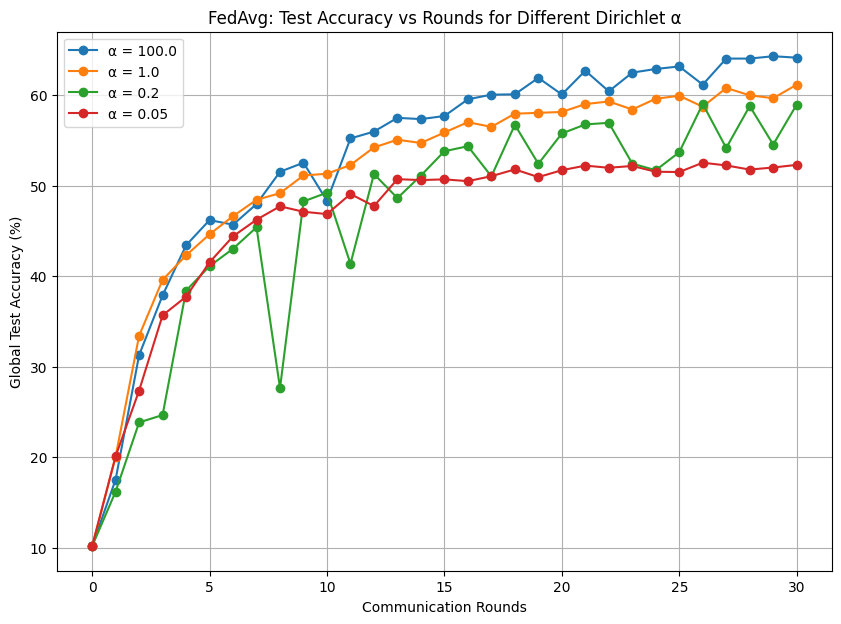

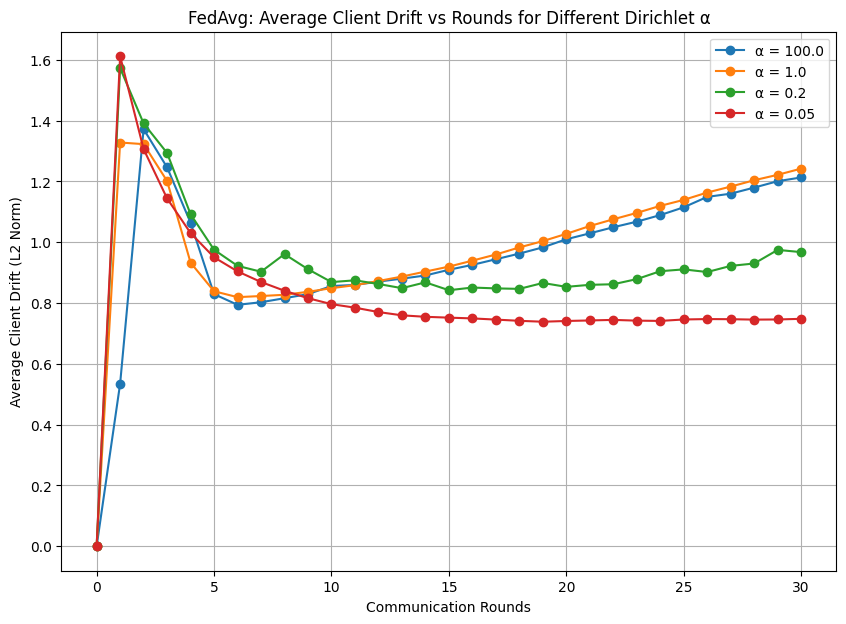

In [7]:
# ============================================================================
# STEP 6: PLOTTING RESULTS (ACCURACY & DRIFT VS ROUNDS)
# ============================================================================

rounds = range(TOTAL_ROUNDS + 1)  # includes round 0

# --- Plot 1: Test Accuracy vs Rounds for different α ---
plt.figure(figsize=(10, 7))
for alpha, history in alpha_histories.items():
    plt.plot(rounds, history["test_accuracy"], marker="o", linestyle="-", label=f"α = {alpha}")
plt.xlabel("Communication Rounds")
plt.ylabel("Global Test Accuracy (%)")
plt.title("FedAvg: Test Accuracy vs Rounds for Different Dirichlet α")
plt.grid(True)
plt.legend()
plt.show()

# --- Plot 2: Average Client Drift vs Rounds for different α ---
plt.figure(figsize=(10, 7))
for alpha, history in alpha_histories.items():
    plt.plot(rounds, history["avg_client_drift"], marker="o", linestyle="-", label=f"α = {alpha}")
plt.xlabel("Communication Rounds")
plt.ylabel("Average Client Drift (L2 Norm)")
plt.title("FedAvg: Average Client Drift vs Rounds for Different Dirichlet α")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# ============================================================================
# STEP 7: SUMMARY TABLE (FOR YOUR REPORT) + PRINTABLE NUMBERS
# ============================================================================

print("\n=== Summary Table: Final Accuracy & Peak Drift for Each α ===\n")
print("| α (Dirichlet) | Final Test Accuracy (%) | Peak Avg Client Drift |")
print("| :-----------: | :----------------------:| :--------------------: |")

summary_stats = {}  # Optional dict to keep around

for alpha, history in alpha_histories.items():
    final_acc = history["test_accuracy"][-1]
    peak_drift = max(history["avg_client_drift"])
    summary_stats[alpha] = {
        "final_acc": final_acc,
        "peak_drift": peak_drift
    }
    print(f"| {alpha:<11} | {final_acc:>23.2f} | {peak_drift:>20.4f} |")




=== Summary Table: Final Accuracy & Peak Drift for Each α ===

| α (Dirichlet) | Final Test Accuracy (%) | Peak Avg Client Drift |
| :-----------: | :----------------------:| :--------------------: |
| 100.0       |                   64.15 |               1.3719 |
| 1.0         |                   61.16 |               1.3279 |
| 0.2         |                   58.96 |               1.5728 |
| 0.05        |                   52.30 |               1.6117 |

You can copy this table into your report directly.


In [9]:
# ============================================================================
# STEP 8: (OPTIONAL) EXTRA PRINTS FOR ANALYSIS
# ============================================================================
# These are handy to share back with me so I can give you a tailored analysis.

print("\n=== Extra Snapshot: Test Accuracy at Selected Rounds ===")
selected_rounds = [0, 5, 10, 20, TOTAL_ROUNDS]
for alpha, history in alpha_histories.items():
    print(f"\nα = {alpha}")
    for r in selected_rounds:
        if r <= TOTAL_ROUNDS:
            acc = history["test_accuracy"][r]
            print(f"  Round {r:2d}: {acc:6.2f}%")

print("\n=== Extra Snapshot: Label Distribution for α = 100 and α = 0.05 (Client 0 only) ===")
for alpha in [100.0, 0.05]:
    dists = alpha_label_distributions.get(alpha, None)
    if dists is None:
        print(f"No label distributions stored for α = {alpha}")
        continue
    counts = dists[0]
    total = counts.sum()
    print(f"\nα = {alpha}, Client 0 label counts (total {total} samples):")
    for c in range(NUM_CLASSES):
        print(f"  Class {c}: {counts[c]} ({counts[c]/total*100:.1f}%)")



=== Extra Snapshot: Test Accuracy at Selected Rounds ===

α = 100.0
  Round  0:  10.15%
  Round  5:  46.20%
  Round 10:  48.33%
  Round 20:  60.08%
  Round 30:  64.15%

α = 1.0
  Round  0:  10.15%
  Round  5:  44.63%
  Round 10:  51.32%
  Round 20:  58.15%
  Round 30:  61.16%

α = 0.2
  Round  0:  10.15%
  Round  5:  41.11%
  Round 10:  49.23%
  Round 20:  55.77%
  Round 30:  58.96%

α = 0.05
  Round  0:  10.15%
  Round  5:  41.53%
  Round 10:  46.86%
  Round 20:  51.71%
  Round 30:  52.30%

=== Extra Snapshot: Label Distribution for α = 100 and α = 0.05 (Client 0 only) ===

α = 100.0, Client 0 label counts (total 9635 samples):
  Class 0: 1106 (11.5%)
  Class 1: 892 (9.3%)
  Class 2: 1029 (10.7%)
  Class 3: 1009 (10.5%)
  Class 4: 918 (9.5%)
  Class 5: 983 (10.2%)
  Class 6: 840 (8.7%)
  Class 7: 878 (9.1%)
  Class 8: 963 (10.0%)
  Class 9: 1017 (10.6%)

α = 0.05, Client 0 label counts (total 5109 samples):
  Class 0: 1 (0.0%)
  Class 1: 0 (0.0%)
  Class 2: 0 (0.0%)
  Class 3: 1 (0.0